In [1]:
import asyncio
import os
from pathlib import Path

# Load environment variables from .env file
try:
    from dotenv import load_dotenv
    # Load .env file from the repository root
    repo_root = Path.cwd()
    env_path = repo_root / ".env"
    if env_path.exists():
        load_dotenv(env_path)
        print(f"✓ Loaded environment variables from {env_path}")
    else:
        print(f"⚠️  .env file not found at {env_path}")
        print("   Create a .env file in the repo root with: TINKER_API_KEY=your-key-here")
except ImportError:
    print("⚠️  python-dotenv not installed. Install with: pip install python-dotenv")
    print("   Or set TINKER_API_KEY manually in this cell")

# Check if TINKER_API_KEY is set
if "TINKER_API_KEY" not in os.environ or os.environ["TINKER_API_KEY"] == "":
    raise ValueError(
        "TINKER_API_KEY is not set. "
        "Create a .env file in the repo root with: TINKER_API_KEY=your-key-here"
    )
else:
    print(f"✓ TINKER_API_KEY is set (length: {len(os.environ['TINKER_API_KEY'])} characters)")

import tinker
from tinker_cookbook import model_info
from tinker_cookbook.hyperparam_utils import get_lr
from tinker_cookbook.renderers import TrainOnWhat
from tinker_cookbook.supervised import train
from tinker_cookbook.supervised.data import FromConversationFileBuilder
from tinker_cookbook.supervised.types import ChatDatasetBuilderCommonConfig
from tinker_cookbook.eval.inspect_evaluators import InspectEvaluator, InspectEvaluatorBuilder

print("Imports complete!")


✓ Loaded environment variables from /Users/rohansubramani/repos/tinker-cookbook/.env
✓ TINKER_API_KEY is set (length: 73 characters)


/Users/rohansubramani/repos/tinker-cookbook/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Imports complete!


In [2]:
# Configuration
model_name = "meta-llama/Llama-3.1-8B-Instruct"
renderer_name = model_info.get_recommended_renderer_name(model_name)
learning_rate = get_lr(model_name, is_lora=True)
log_path = "/tmp/tinker-test"

print(f"Model: {model_name}")
print(f"Renderer: {renderer_name}")
print(f"Learning rate: {learning_rate}")

# Set up dataset builder - use conversations.jsonl from example_data
# In a notebook, we need to find the file relative to the notebook location
# or use an absolute path. Let's try to find it relative to the repo root.
import sys
from pathlib import Path

# Try to find the file - adjust path as needed
repo_root = Path.cwd()
example_data_path = repo_root / "tinker_cookbook" / "example_data" / "conversations.jsonl"

if not example_data_path.exists():
    # Fallback: try parent directory if running from a subdirectory
    example_data_path = repo_root.parent / "tinker_cookbook" / "example_data" / "conversations.jsonl"

if not example_data_path.exists():
    raise FileNotFoundError(f"Could not find conversations.jsonl at {example_data_path}")

print(f"Using dataset: {example_data_path}")

common_config = ChatDatasetBuilderCommonConfig(
    model_name_for_tokenizer=model_name,
    renderer_name=renderer_name,
    max_length=8192,
    batch_size=2,  # Small batch size for demo
    train_on_what=TrainOnWhat.ALL_ASSISTANT_MESSAGES,
)

# Create dataset builder - use 10 examples for training, 5 for test
dataset_builder = FromConversationFileBuilder(
    common_config=common_config,
    file_path=str(example_data_path),
    test_size=5,  # Reserve 5 examples for test
    shuffle_seed=42,
)

# Create training config
# Enable checkpointing so we can evaluate the finetuned model
config = train.Config(
    log_path=log_path,
    model_name=model_name,
    dataset_builder=dataset_builder,
    learning_rate=learning_rate,
    lr_schedule="linear",
    num_epochs=1,
    eval_every=0,  # Disable eval during training for simplicity
    save_every=5,  # Save checkpoint after every 5 steps (after all training)
    # batch_size=2,  # This is actually set in common_config, but keeping for clarity
)

print(f"\nTraining configuration:")
print(f"  Training examples: 10 (batch_size=2, so 5 batches)")
print(f"  Test examples: 5")
print(f"  Learning rate: {learning_rate:.2e}")
print(f"\nStarting training...")

# Run training
# In Jupyter notebooks, use await instead of asyncio.run()
await train.main(config)

# The training loop automatically saves a final checkpoint
# Let's verify it exists and get the path
from tinker_cookbook import checkpoint_utils
last_checkpoint = checkpoint_utils.get_last_checkpoint(log_path, required_key="sampler_path")

print("\nTraining complete!")
if last_checkpoint:
    model_path = last_checkpoint["sampler_path"]
    print(f"Final model path: {model_path}")
    print(f"This path will be used for evaluation in the next cell.")
else:
    print("Warning: No checkpoint found. The training may not have saved checkpoints.")
    print("Check the log directory:", log_path)


Model: meta-llama/Llama-3.1-8B-Instruct
Renderer: llama3
Learning rate: 0.0002856415043086949
Using dataset: /Users/rohansubramani/repos/tinker-cookbook/tinker_cookbook/example_data/conversations.jsonl

Training configuration:
  Training examples: 10 (batch_size=2, so 5 batches)
  Test examples: 5
  Learning rate: 2.86e-04

Starting training...


tinker_cookbook.utils.ml_log:477 [INFO] Logging to: /tmp/tinker-test
tinker.lib.public_interfaces.service_client:66 [INFO] ServiceClient initialized for session 9a59b975-a813-56b8-95f1-e97245ca9dda
tinker.lib.public_interfaces.service_client:147 [INFO] TrainingClient initialized for model 9a59b975-a813-56b8-95f1-e97245ca9dda:train:0
tinker_cookbook.supervised.train:229 [INFO] Training for 61 batches x 1 epochs = 61 steps
tinker_cookbook.supervised.train:344 [INFO] Starting epoch 0
tinker_cookbook.utils.misc_utils:20 [INFO] Starting get_batch
tinker_cookbook.utils.misc_utils:23 [INFO] get_batch took 0.00 seconds
tinker_cookbook.supervised.train:259 [INFO] <|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are a language teacher.<|eot_id|><|start_header_id|>user<|end_header_id|>

Translate 'Good morning' to French.<|eot_id|><|start_header_id|>assistant<|end_header_id|>

'Good morning' in French is 'Bonjour'.<|eot_id|>
tinker_cookbook.utils.misc_utils:20 [INFO] Starting get_

tinker_cookbook.utils.ml_log:197 [INFO] 
                    Step 0                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                         ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ epoch                          │ 0         │
│ learning_rate                  │ 0.000286  │
│ num_loss_tokens                │ 28.000000 │
│ num_sequences                  │ 2         │
│ num_tokens                     │ 74        │
│ progress                       │ 0.016393  │
│ time/get_batch                 │ 0.001226  │
│ time/step                      │ 28.395439 │
│ time/total                     │ 28.416452 │
│ train_mean_nll                 │ 0.884809  │
└────────────────────────────────┴───────────┘
tinker_cookbook.utils.misc_utils:20 [INFO] Starting get_batch
tinker_cookbook.utils.misc_utils:23 [INFO] get_batch took 0.00 seconds
tinker_cookbook.supervised.train:259 [INFO] <|begin_of_text|><|start_header_id|>user<|end_header_id|>

What is the capita

tinker_cookbook.utils.ml_log:197 [INFO] 
                    Step 1                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                         ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ epoch                          │ 0         │
│ learning_rate                  │ 0.000281  │
│ num_loss_tokens                │ 29.000000 │
│ num_sequences                  │ 2         │
│ num_tokens                     │ 76        │
│ progress                       │ 0.032787  │
│ time/get_batch                 │ 0.001470  │
│ time/step                      │ 10.461675 │
│ time/total                     │ 38.887409 │
│ train_mean_nll                 │ 2.001821  │
└────────────────────────────────┴───────────┘
tinker_cookbook.utils.misc_utils:20 [INFO] Starting get_batch
tinker_cookbook.utils.misc_utils:23 [INFO] get_batch took 0.00 seconds
tinker_cookbook.supervised.train:259 [INFO] <|begin_of_text|><|start_header_id|>user<|end_header_id|>

Who wrote 'Pride a

tinker_cookbook.utils.ml_log:197 [INFO] 
                    Step 2                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                         ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ epoch                          │ 0         │
│ learning_rate                  │ 0.000276  │
│ num_loss_tokens                │ 42.000000 │
│ num_sequences                  │ 2         │
│ num_tokens                     │ 84        │
│ progress                       │ 0.049180  │
│ time/get_batch                 │ 0.002311  │
│ time/step                      │ 0.210775  │
│ time/total                     │ 10.688157 │
│ train_mean_nll                 │ 0.771827  │
└────────────────────────────────┴───────────┘
tinker_cookbook.utils.misc_utils:20 [INFO] Starting get_batch
tinker_cookbook.utils.misc_utils:23 [INFO] get_batch took 0.00 seconds
tinker_cookbook.supervised.train:259 [INFO] <|begin_of_text|><|start_header_id|>user<|end_header_id|>

Who developed the 

tinker_cookbook.utils.ml_log:197 [INFO] 
                    Step 3                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                         ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ epoch                          │ 0         │
│ learning_rate                  │ 0.000272  │
│ num_loss_tokens                │ 30.000000 │
│ num_sequences                  │ 2         │
│ num_tokens                     │ 77        │
│ progress                       │ 0.065574  │
│ time/get_batch                 │ 0.003624  │
│ time/step                      │ 1.279096  │
│ time/total                     │ 1.504230  │
│ train_mean_nll                 │ 0.846990  │
└────────────────────────────────┴───────────┘
tinker_cookbook.utils.misc_utils:20 [INFO] Starting get_batch
tinker_cookbook.utils.misc_utils:23 [INFO] get_batch took 0.00 seconds
tinker_cookbook.supervised.train:259 [INFO] <|begin_of_text|><|start_header_id|>user<|end_header_id|>

What is the capita

tinker_cookbook.utils.ml_log:197 [INFO] 
                    Step 4                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                         ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ epoch                          │ 0         │
│ learning_rate                  │ 0.000267  │
│ num_loss_tokens                │ 20.000000 │
│ num_sequences                  │ 2         │
│ num_tokens                     │ 52        │
│ progress                       │ 0.081967  │
│ time/get_batch                 │ 0.002277  │
│ time/step                      │ 0.915215  │
│ time/total                     │ 2.206741  │
│ train_mean_nll                 │ 0.115983  │
└────────────────────────────────┴───────────┘
tinker_cookbook.utils.misc_utils:20 [INFO] Starting get_batch
tinker_cookbook.utils.misc_utils:23 [INFO] get_batch took 0.00 seconds
tinker_cookbook.supervised.train:259 [INFO] <|begin_of_text|><|start_header_id|>user<|end_header_id|>

What is the capita

tinker_cookbook.utils.ml_log:197 [INFO] 
                    Step 5                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                         ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ epoch                          │ 0         │
│ learning_rate                  │ 0.000262  │
│ num_loss_tokens                │ 19.000000 │
│ num_sequences                  │ 2         │
│ num_tokens                     │ 54        │
│ progress                       │ 0.098361  │
│ time/get_batch                 │ 0.002443  │
│ time/save_checkpoint           │ 16.531885 │
│ time/step                      │ 0.000331  │
│ time/total                     │ 17.463107 │
│ train_mean_nll                 │ 0.021265  │
└────────────────────────────────┴───────────┘
tinker_cookbook.utils.misc_utils:20 [INFO] Starting get_batch
tinker_cookbook.utils.misc_utils:23 [INFO] get_batch took 0.00 seconds
tinker_cookbook.supervised.train:259 [INFO] <|begin_of_text|><|start_heade

tinker_cookbook.utils.ml_log:197 [INFO] 
                    Step 6                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                         ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ epoch                          │ 0         │
│ learning_rate                  │ 0.000258  │
│ num_loss_tokens                │ 32.000000 │
│ num_sequences                  │ 2         │
│ num_tokens                     │ 77        │
│ progress                       │ 0.114754  │
│ time/get_batch                 │ 0.003758  │
│ time/step                      │ 0.000470  │
│ time/total                     │ 16.546728 │
│ train_mean_nll                 │ 0.526935  │
└────────────────────────────────┴───────────┘
tinker_cookbook.utils.misc_utils:20 [INFO] Starting get_batch
tinker_cookbook.utils.misc_utils:23 [INFO] get_batch took 0.00 seconds
tinker_cookbook.supervised.train:259 [INFO] <|begin_of_text|><|start_header_id|>user<|end_header_id|>

What is the square

tinker_cookbook.utils.ml_log:197 [INFO] 
                    Step 7                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                         ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ epoch                          │ 0         │
│ learning_rate                  │ 0.000253  │
│ num_loss_tokens                │ 37.000000 │
│ num_sequences                  │ 2         │
│ num_tokens                     │ 82        │
│ progress                       │ 0.131148  │
│ time/get_batch                 │ 0.001991  │
│ time/step                      │ 1.742229  │
│ time/total                     │ 1.754661  │
│ train_mean_nll                 │ 0.627311  │
└────────────────────────────────┴───────────┘
tinker_cookbook.utils.misc_utils:20 [INFO] Starting get_batch
tinker_cookbook.utils.misc_utils:23 [INFO] get_batch took 0.00 seconds
tinker_cookbook.supervised.train:259 [INFO] <|begin_of_text|><|start_header_id|>user<|end_header_id|>

Who was Albert Ein

tinker_cookbook.utils.ml_log:197 [INFO] 
                    Step 8                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                         ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ epoch                          │ 0         │
│ learning_rate                  │ 0.000248  │
│ num_loss_tokens                │ 29.000000 │
│ num_sequences                  │ 2         │
│ num_tokens                     │ 74        │
│ progress                       │ 0.147541  │
│ time/get_batch                 │ 0.002054  │
│ time/step                      │ 0.939100  │
│ time/total                     │ 2.696492  │
│ train_mean_nll                 │ 1.295805  │
└────────────────────────────────┴───────────┘
tinker_cookbook.utils.misc_utils:20 [INFO] Starting get_batch
tinker_cookbook.utils.misc_utils:23 [INFO] get_batch took 0.00 seconds
tinker_cookbook.supervised.train:259 [INFO] <|begin_of_text|><|start_header_id|>user<|end_header_id|>

What is 11 times 1

tinker_cookbook.utils.ml_log:197 [INFO] 
                    Step 9                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                         ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ epoch                          │ 0         │
│ learning_rate                  │ 0.000243  │
│ num_loss_tokens                │ 26.000000 │
│ num_sequences                  │ 2         │
│ num_tokens                     │ 57        │
│ progress                       │ 0.163934  │
│ time/get_batch                 │ 0.003463  │
│ time/step                      │ 1.672524  │
│ time/total                     │ 2.630465  │
│ train_mean_nll                 │ 0.508920  │
└────────────────────────────────┴───────────┘
tinker_cookbook.utils.misc_utils:20 [INFO] Starting get_batch
tinker_cookbook.utils.misc_utils:23 [INFO] get_batch took 0.00 seconds
tinker_cookbook.supervised.train:259 [INFO] <|begin_of_text|><|start_header_id|>user<|end_header_id|>

What is the talles

tinker_cookbook.utils.ml_log:197 [INFO] 
                   Step 10                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                         ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ epoch                          │ 0         │
│ learning_rate                  │ 0.000239  │
│ num_loss_tokens                │ 21.000000 │
│ num_sequences                  │ 2         │
│ num_tokens                     │ 57        │
│ progress                       │ 0.180328  │
│ time/get_batch                 │ 0.003940  │
│ time/save_checkpoint           │ 5.715000  │
│ time/step                      │ 0.000763  │
│ time/total                     │ 7.407682  │
│ train_mean_nll                 │ 0.323413  │
└────────────────────────────────┴───────────┘
tinker_cookbook.utils.misc_utils:20 [INFO] Starting get_batch
tinker_cookbook.utils.misc_utils:23 [INFO] get_batch took 0.00 seconds
tinker_cookbook.supervised.train:259 [INFO] <|begin_of_text|><|start_heade

tinker_cookbook.utils.ml_log:197 [INFO] 
                   Step 11                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                         ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ epoch                          │ 0         │
│ learning_rate                  │ 0.000234  │
│ num_loss_tokens                │ 66.000000 │
│ num_sequences                  │ 2         │
│ num_tokens                     │ 112       │
│ progress                       │ 0.196721  │
│ time/get_batch                 │ 0.003837  │
│ time/step                      │ 0.001555  │
│ time/total                     │ 5.736192  │
│ train_mean_nll                 │ 0.697655  │
└────────────────────────────────┴───────────┘
tinker_cookbook.utils.misc_utils:20 [INFO] Starting get_batch
tinker_cookbook.utils.misc_utils:23 [INFO] get_batch took 0.00 seconds
tinker_cookbook.supervised.train:259 [INFO] <|begin_of_text|><|start_header_id|>user<|end_header_id|>

What is 14 multipl

tinker_cookbook.utils.ml_log:197 [INFO] 
                   Step 12                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                         ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ epoch                          │ 0         │
│ learning_rate                  │ 0.000229  │
│ num_loss_tokens                │ 33.000000 │
│ num_sequences                  │ 2         │
│ num_tokens                     │ 77        │
│ progress                       │ 0.213115  │
│ time/get_batch                 │ 0.003722  │
│ time/step                      │ 1.578610  │
│ time/total                     │ 1.597971  │
│ train_mean_nll                 │ 0.263975  │
└────────────────────────────────┴───────────┘
tinker_cookbook.utils.misc_utils:20 [INFO] Starting get_batch
tinker_cookbook.utils.misc_utils:23 [INFO] get_batch took 0.00 seconds
tinker_cookbook.supervised.train:259 [INFO] <|begin_of_text|><|start_header_id|>user<|end_header_id|>

What is the chemic

tinker_cookbook.utils.ml_log:197 [INFO] 
                   Step 13                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                         ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ epoch                          │ 0         │
│ learning_rate                  │ 0.000225  │
│ num_loss_tokens                │ 19.000000 │
│ num_sequences                  │ 2         │
│ num_tokens                     │ 54        │
│ progress                       │ 0.229508  │
│ time/get_batch                 │ 0.003016  │
│ time/step                      │ 1.029989  │
│ time/total                     │ 2.624172  │
│ train_mean_nll                 │ 0.079228  │
└────────────────────────────────┴───────────┘
tinker_cookbook.utils.misc_utils:20 [INFO] Starting get_batch
tinker_cookbook.utils.misc_utils:23 [INFO] get_batch took 0.00 seconds
tinker_cookbook.supervised.train:259 [INFO] <|begin_of_text|><|start_header_id|>user<|end_header_id|>

Which planet is cl

tinker_cookbook.utils.ml_log:197 [INFO] 
                   Step 14                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                         ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ epoch                          │ 0         │
│ learning_rate                  │ 0.000220  │
│ num_loss_tokens                │ 21.000000 │
│ num_sequences                  │ 2         │
│ num_tokens                     │ 54        │
│ progress                       │ 0.245902  │
│ time/get_batch                 │ 0.002770  │
│ time/step                      │ 0.940380  │
│ time/total                     │ 1.987619  │
│ train_mean_nll                 │ 0.294357  │
└────────────────────────────────┴───────────┘
tinker_cookbook.utils.misc_utils:20 [INFO] Starting get_batch
tinker_cookbook.utils.misc_utils:23 [INFO] get_batch took 0.00 seconds
tinker_cookbook.supervised.train:259 [INFO] <|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are a movie 

tinker_cookbook.utils.ml_log:197 [INFO] 
                   Step 15                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                         ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ epoch                          │ 0         │
│ learning_rate                  │ 0.000215  │
│ num_loss_tokens                │ 27.000000 │
│ num_sequences                  │ 2         │
│ num_tokens                     │ 64        │
│ progress                       │ 0.262295  │
│ time/get_batch                 │ 0.004175  │
│ time/save_checkpoint           │ 7.410455  │
│ time/step                      │ 0.001083  │
│ time/total                     │ 8.372604  │
│ train_mean_nll                 │ 0.322217  │
└────────────────────────────────┴───────────┘
tinker_cookbook.utils.misc_utils:20 [INFO] Starting get_batch
tinker_cookbook.utils.misc_utils:23 [INFO] get_batch took 0.00 seconds
tinker_cookbook.supervised.train:259 [INFO] <|begin_of_text|><|start_heade

tinker_cookbook.utils.ml_log:197 [INFO] 
                   Step 16                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                         ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ epoch                          │ 0         │
│ learning_rate                  │ 0.000211  │
│ num_loss_tokens                │ 23.000000 │
│ num_sequences                  │ 2         │
│ num_tokens                     │ 67        │
│ progress                       │ 0.278689  │
│ time/get_batch                 │ 0.004601  │
│ time/step                      │ 0.001152  │
│ time/total                     │ 7.434108  │
│ train_mean_nll                 │ 0.159950  │
└────────────────────────────────┴───────────┘
tinker_cookbook.utils.misc_utils:20 [INFO] Starting get_batch
tinker_cookbook.utils.misc_utils:23 [INFO] get_batch took 0.00 seconds
tinker_cookbook.supervised.train:259 [INFO] <|begin_of_text|><|start_header_id|>user<|end_header_id|>

Who wrote 'The Ody

tinker_cookbook.utils.ml_log:197 [INFO] 
                   Step 17                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                         ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ epoch                          │ 0         │
│ learning_rate                  │ 0.000206  │
│ num_loss_tokens                │ 18.000000 │
│ num_sequences                  │ 2         │
│ num_tokens                     │ 52        │
│ progress                       │ 0.295082  │
│ time/get_batch                 │ 0.004409  │
│ time/step                      │ 2.724510  │
│ time/total                     │ 2.747004  │
│ train_mean_nll                 │ 0.133753  │
└────────────────────────────────┴───────────┘
tinker_cookbook.utils.misc_utils:20 [INFO] Starting get_batch
tinker_cookbook.utils.misc_utils:23 [INFO] get_batch took 0.00 seconds
tinker_cookbook.supervised.train:259 [INFO] <|begin_of_text|><|start_header_id|>user<|end_header_id|>

How many planets a

tinker_cookbook.utils.ml_log:197 [INFO] 
                   Step 18                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                         ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ epoch                          │ 0         │
│ learning_rate                  │ 0.000201  │
│ num_loss_tokens                │ 37.000000 │
│ num_sequences                  │ 2         │
│ num_tokens                     │ 67        │
│ progress                       │ 0.311475  │
│ time/get_batch                 │ 0.005591  │
│ time/step                      │ 1.068346  │
│ time/total                     │ 3.810047  │
│ train_mean_nll                 │ 0.195785  │
└────────────────────────────────┴───────────┘
tinker_cookbook.utils.misc_utils:20 [INFO] Starting get_batch
tinker_cookbook.utils.misc_utils:23 [INFO] get_batch took 0.00 seconds
tinker_cookbook.supervised.train:259 [INFO] <|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are a space 

tinker_cookbook.utils.ml_log:197 [INFO] 
                   Step 19                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                         ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ epoch                          │ 0         │
│ learning_rate                  │ 0.000197  │
│ num_loss_tokens                │ 24.000000 │
│ num_sequences                  │ 2         │
│ num_tokens                     │ 61        │
│ progress                       │ 0.327869  │
│ time/get_batch                 │ 0.003066  │
│ time/step                      │ 0.762874  │
│ time/total                     │ 1.849839  │
│ train_mean_nll                 │ 0.140409  │
└────────────────────────────────┴───────────┘
tinker_cookbook.utils.misc_utils:20 [INFO] Starting get_batch
tinker_cookbook.utils.misc_utils:23 [INFO] get_batch took 0.00 seconds
tinker_cookbook.supervised.train:259 [INFO] <|begin_of_text|><|start_header_id|>user<|end_header_id|>

How many stripes a

tinker_cookbook.utils.ml_log:197 [INFO] 
                   Step 20                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                         ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ epoch                          │ 0         │
│ learning_rate                  │ 0.000192  │
│ num_loss_tokens                │ 38.000000 │
│ num_sequences                  │ 2         │
│ num_tokens                     │ 82        │
│ progress                       │ 0.344262  │
│ time/get_batch                 │ 0.004179  │
│ time/save_checkpoint           │ 6.180529  │
│ time/step                      │ 0.000746  │
│ time/total                     │ 6.961775  │
│ train_mean_nll                 │ 0.515367  │
└────────────────────────────────┴───────────┘
tinker_cookbook.utils.misc_utils:20 [INFO] Starting get_batch
tinker_cookbook.utils.misc_utils:23 [INFO] get_batch took 0.00 seconds
tinker_cookbook.supervised.train:259 [INFO] <|begin_of_text|><|start_heade

tinker_cookbook.utils.ml_log:197 [INFO] 
                   Step 21                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                         ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ epoch                          │ 0         │
│ learning_rate                  │ 0.000187  │
│ num_loss_tokens                │ 24.000000 │
│ num_sequences                  │ 2         │
│ num_tokens                     │ 58        │
│ progress                       │ 0.360656  │
│ time/get_batch                 │ 0.002831  │
│ time/step                      │ 0.003056  │
│ time/total                     │ 6.201719  │
│ train_mean_nll                 │ 0.198310  │
└────────────────────────────────┴───────────┘
tinker_cookbook.utils.misc_utils:20 [INFO] Starting get_batch
tinker_cookbook.utils.misc_utils:23 [INFO] get_batch took 0.00 seconds
tinker_cookbook.supervised.train:259 [INFO] <|begin_of_text|><|start_header_id|>user<|end_header_id|>

What is the capita

tinker_cookbook.utils.ml_log:197 [INFO] 
                   Step 22                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                         ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ epoch                          │ 0         │
│ learning_rate                  │ 0.000183  │
│ num_loss_tokens                │ 39.000000 │
│ num_sequences                  │ 2         │
│ num_tokens                     │ 77        │
│ progress                       │ 0.377049  │
│ time/get_batch                 │ 0.003876  │
│ time/step                      │ 2.180641  │
│ time/total                     │ 2.201474  │
│ train_mean_nll                 │ 0.727630  │
└────────────────────────────────┴───────────┘
tinker_cookbook.utils.misc_utils:20 [INFO] Starting get_batch
tinker_cookbook.utils.misc_utils:23 [INFO] get_batch took 0.00 seconds
tinker_cookbook.supervised.train:259 [INFO] <|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are a sports

tinker_cookbook.utils.ml_log:197 [INFO] 
                   Step 23                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                         ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ epoch                          │ 0         │
│ learning_rate                  │ 0.000178  │
│ num_loss_tokens                │ 35.000000 │
│ num_sequences                  │ 2         │
│ num_tokens                     │ 79        │
│ progress                       │ 0.393443  │
│ time/get_batch                 │ 0.004090  │
│ time/step                      │ 1.049571  │
│ time/total                     │ 3.246482  │
│ train_mean_nll                 │ 0.355117  │
└────────────────────────────────┴───────────┘
tinker_cookbook.utils.misc_utils:20 [INFO] Starting get_batch
tinker_cookbook.utils.misc_utils:23 [INFO] get_batch took 0.00 seconds
tinker_cookbook.supervised.train:259 [INFO] <|begin_of_text|><|start_header_id|>user<|end_header_id|>

What is 90 divided

tinker_cookbook.utils.ml_log:197 [INFO] 
                   Step 24                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                         ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ epoch                          │ 0         │
│ learning_rate                  │ 0.000173  │
│ num_loss_tokens                │ 25.000000 │
│ num_sequences                  │ 2         │
│ num_tokens                     │ 75        │
│ progress                       │ 0.409836  │
│ time/get_batch                 │ 0.003456  │
│ time/step                      │ 1.696663  │
│ time/total                     │ 2.763265  │
│ train_mean_nll                 │ 0.138741  │
└────────────────────────────────┴───────────┘
tinker_cookbook.utils.misc_utils:20 [INFO] Starting get_batch
tinker_cookbook.utils.misc_utils:23 [INFO] get_batch took 0.00 seconds
tinker_cookbook.supervised.train:259 [INFO] <|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are a helpfu

tinker_cookbook.utils.ml_log:197 [INFO] 
                   Step 25                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                         ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ epoch                          │ 0         │
│ learning_rate                  │ 0.000169  │
│ num_loss_tokens                │ 19.000000 │
│ num_sequences                  │ 2         │
│ num_tokens                     │ 53        │
│ progress                       │ 0.426230  │
│ time/get_batch                 │ 0.003104  │
│ time/save_checkpoint           │ 4.443836  │
│ time/step                      │ 0.000979  │
│ time/total                     │ 6.161621  │
│ train_mean_nll                 │ 0.008312  │
└────────────────────────────────┴───────────┘
tinker_cookbook.utils.misc_utils:20 [INFO] Starting get_batch
tinker_cookbook.utils.misc_utils:23 [INFO] get_batch took 0.00 seconds
tinker_cookbook.supervised.train:259 [INFO] <|begin_of_text|><|start_heade

tinker_cookbook.utils.ml_log:197 [INFO] 
                   Step 26                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                         ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ epoch                          │ 0         │
│ learning_rate                  │ 0.000164  │
│ num_loss_tokens                │ 49.000000 │
│ num_sequences                  │ 2         │
│ num_tokens                     │ 97        │
│ progress                       │ 0.442623  │
│ time/get_batch                 │ 0.004629  │
│ time/step                      │ 0.002319  │
│ time/total                     │ 4.467114  │
│ train_mean_nll                 │ 0.660682  │
└────────────────────────────────┴───────────┘
tinker_cookbook.utils.misc_utils:20 [INFO] Starting get_batch
tinker_cookbook.utils.misc_utils:23 [INFO] get_batch took 0.00 seconds
tinker_cookbook.supervised.train:259 [INFO] <|begin_of_text|><|start_header_id|>user<|end_header_id|>

Write a haiku abou

tinker_cookbook.utils.ml_log:197 [INFO] 
                   Step 27                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                         ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ epoch                          │ 0         │
│ learning_rate                  │ 0.000159  │
│ num_loss_tokens                │ 16.000000 │
│ num_sequences                  │ 2         │
│ num_tokens                     │ 48        │
│ progress                       │ 0.459016  │
│ time/get_batch                 │ 0.003071  │
│ time/step                      │ 1.875793  │
│ time/total                     │ 1.891737  │
│ train_mean_nll                 │ 0.052064  │
└────────────────────────────────┴───────────┘
tinker_cookbook.utils.misc_utils:20 [INFO] Starting get_batch
tinker_cookbook.utils.misc_utils:23 [INFO] get_batch took 0.00 seconds
tinker_cookbook.supervised.train:259 [INFO] <|begin_of_text|><|start_header_id|>user<|end_header_id|>

Who painted 'Starr

tinker_cookbook.utils.ml_log:197 [INFO] 
                   Step 28                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                         ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ epoch                          │ 0         │
│ learning_rate                  │ 0.000155  │
│ num_loss_tokens                │ 37.000000 │
│ num_sequences                  │ 2         │
│ num_tokens                     │ 68        │
│ progress                       │ 0.475410  │
│ time/get_batch                 │ 0.002142  │
│ time/step                      │ 0.982083  │
│ time/total                     │ 2.871684  │
│ train_mean_nll                 │ 1.305643  │
└────────────────────────────────┴───────────┘
tinker_cookbook.utils.misc_utils:20 [INFO] Starting get_batch
tinker_cookbook.utils.misc_utils:23 [INFO] get_batch took 0.00 seconds
tinker_cookbook.supervised.train:259 [INFO] <|begin_of_text|><|start_header_id|>user<|end_header_id|>

What is the chemic

tinker_cookbook.utils.ml_log:197 [INFO] 
                   Step 29                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                         ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ epoch                          │ 0         │
│ learning_rate                  │ 0.000150  │
│ num_loss_tokens                │ 26.000000 │
│ num_sequences                  │ 2         │
│ num_tokens                     │ 60        │
│ progress                       │ 0.491803  │
│ time/get_batch                 │ 0.003056  │
│ time/step                      │ 0.894015  │
│ time/total                     │ 1.889071  │
│ train_mean_nll                 │ 0.145734  │
└────────────────────────────────┴───────────┘
tinker_cookbook.utils.misc_utils:20 [INFO] Starting get_batch
tinker_cookbook.utils.misc_utils:23 [INFO] get_batch took 0.00 seconds
tinker_cookbook.supervised.train:259 [INFO] <|begin_of_text|><|start_header_id|>user<|end_header_id|>

What is 64 divided

tinker_cookbook.utils.ml_log:197 [INFO] 
                   Step 30                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                         ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ epoch                          │ 0         │
│ learning_rate                  │ 0.000145  │
│ num_loss_tokens                │ 26.000000 │
│ num_sequences                  │ 2         │
│ num_tokens                     │ 68        │
│ progress                       │ 0.508197  │
│ time/get_batch                 │ 0.002687  │
│ time/save_checkpoint           │ 5.018646  │
│ time/step                      │ 0.000907  │
│ time/total                     │ 5.929346  │
│ train_mean_nll                 │ 0.456015  │
└────────────────────────────────┴───────────┘
tinker_cookbook.utils.misc_utils:20 [INFO] Starting get_batch
tinker_cookbook.utils.misc_utils:23 [INFO] get_batch took 0.00 seconds
tinker_cookbook.supervised.train:259 [INFO] <|begin_of_text|><|start_heade

tinker_cookbook.utils.ml_log:197 [INFO] 
                   Step 31                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                         ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ epoch                          │ 0         │
│ learning_rate                  │ 0.000140  │
│ num_loss_tokens                │ 24.000000 │
│ num_sequences                  │ 2         │
│ num_tokens                     │ 57        │
│ progress                       │ 0.524590  │
│ time/get_batch                 │ 0.003063  │
│ time/step                      │ 0.001993  │
│ time/total                     │ 5.041478  │
│ train_mean_nll                 │ 0.051508  │
└────────────────────────────────┴───────────┘
tinker_cookbook.utils.misc_utils:20 [INFO] Starting get_batch
tinker_cookbook.utils.misc_utils:23 [INFO] get_batch took 0.00 seconds
tinker_cookbook.supervised.train:259 [INFO] <|begin_of_text|><|start_header_id|>user<|end_header_id|>

Who wrote 'Hamlet'

tinker_cookbook.utils.ml_log:197 [INFO] 
                   Step 32                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                         ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ epoch                          │ 0         │
│ learning_rate                  │ 0.000136  │
│ num_loss_tokens                │ 21.000000 │
│ num_sequences                  │ 2         │
│ num_tokens                     │ 57        │
│ progress                       │ 0.540984  │
│ time/get_batch                 │ 0.003816  │
│ time/step                      │ 2.007352  │
│ time/total                     │ 2.028072  │
│ train_mean_nll                 │ 0.159410  │
└────────────────────────────────┴───────────┘
tinker_cookbook.utils.misc_utils:20 [INFO] Starting get_batch
tinker_cookbook.utils.misc_utils:23 [INFO] get_batch took 0.00 seconds
tinker_cookbook.supervised.train:259 [INFO] <|begin_of_text|><|start_header_id|>user<|end_header_id|>

Explain what an at

tinker_cookbook.utils.ml_log:197 [INFO] 
                   Step 33                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                         ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ epoch                          │ 0         │
│ learning_rate                  │ 0.000131  │
│ num_loss_tokens                │ 67.000000 │
│ num_sequences                  │ 2         │
│ num_tokens                     │ 99        │
│ progress                       │ 0.557377  │
│ time/get_batch                 │ 0.002877  │
│ time/step                      │ 1.003802  │
│ time/total                     │ 3.029097  │
│ train_mean_nll                 │ 0.851372  │
└────────────────────────────────┴───────────┘
tinker_cookbook.utils.misc_utils:20 [INFO] Starting get_batch
tinker_cookbook.utils.misc_utils:23 [INFO] get_batch took 0.00 seconds
tinker_cookbook.supervised.train:259 [INFO] <|begin_of_text|><|start_header_id|>user<|end_header_id|>

Who painted the Mo

tinker_cookbook.utils.ml_log:197 [INFO] 
                   Step 34                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                         ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ epoch                          │ 0         │
│ learning_rate                  │ 0.000126  │
│ num_loss_tokens                │ 46.000000 │
│ num_sequences                  │ 2         │
│ num_tokens                     │ 79        │
│ progress                       │ 0.573770  │
│ time/get_batch                 │ 0.004366  │
│ time/step                      │ 0.869479  │
│ time/total                     │ 1.896331  │
│ train_mean_nll                 │ 0.230391  │
└────────────────────────────────┴───────────┘
tinker_cookbook.utils.misc_utils:20 [INFO] Starting get_batch
tinker_cookbook.utils.misc_utils:23 [INFO] get_batch took 0.00 seconds
tinker_cookbook.supervised.train:259 [INFO] <|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are a cookin

tinker_cookbook.utils.ml_log:197 [INFO] 
                   Step 35                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                         ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ epoch                          │ 0         │
│ learning_rate                  │ 0.000122  │
│ num_loss_tokens                │ 43.000000 │
│ num_sequences                  │ 2         │
│ num_tokens                     │ 84        │
│ progress                       │ 0.590164  │
│ time/get_batch                 │ 0.004968  │
│ time/save_checkpoint           │ 5.130435  │
│ time/step                      │ 0.001134  │
│ time/total                     │ 6.022283  │
│ train_mean_nll                 │ 0.996005  │
└────────────────────────────────┴───────────┘
tinker_cookbook.utils.misc_utils:20 [INFO] Starting get_batch
tinker_cookbook.utils.misc_utils:23 [INFO] get_batch took 0.00 seconds
tinker_cookbook.supervised.train:259 [INFO] <|begin_of_text|><|start_heade

tinker_cookbook.utils.ml_log:197 [INFO] 
                   Step 36                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                         ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ epoch                          │ 0         │
│ learning_rate                  │ 0.000117  │
│ num_loss_tokens                │ 44.000000 │
│ num_sequences                  │ 2         │
│ num_tokens                     │ 98        │
│ progress                       │ 0.606557  │
│ time/get_batch                 │ 0.003255  │
│ time/step                      │ 0.001148  │
│ time/total                     │ 5.149557  │
│ train_mean_nll                 │ 2.113963  │
└────────────────────────────────┴───────────┘
tinker_cookbook.utils.misc_utils:20 [INFO] Starting get_batch
tinker_cookbook.utils.misc_utils:23 [INFO] get_batch took 0.00 seconds
tinker_cookbook.supervised.train:259 [INFO] <|begin_of_text|><|start_header_id|>user<|end_header_id|>

What organ pumps b

tinker_cookbook.utils.ml_log:197 [INFO] 
                   Step 37                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                         ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ epoch                          │ 0         │
│ learning_rate                  │ 0.000112  │
│ num_loss_tokens                │ 49.000000 │
│ num_sequences                  │ 2         │
│ num_tokens                     │ 80        │
│ progress                       │ 0.622951  │
│ time/get_batch                 │ 0.002906  │
│ time/step                      │ 1.632296  │
│ time/total                     │ 1.647029  │
│ train_mean_nll                 │ 0.354482  │
└────────────────────────────────┴───────────┘
tinker_cookbook.utils.misc_utils:20 [INFO] Starting get_batch
tinker_cookbook.utils.misc_utils:23 [INFO] get_batch took 0.00 seconds
tinker_cookbook.supervised.train:259 [INFO] <|begin_of_text|><|start_header_id|>user<|end_header_id|>

What year did the 

tinker_cookbook.utils.ml_log:197 [INFO] 
                   Step 38                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                         ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ epoch                          │ 0         │
│ learning_rate                  │ 0.000108  │
│ num_loss_tokens                │ 20.000000 │
│ num_sequences                  │ 2         │
│ num_tokens                     │ 55        │
│ progress                       │ 0.639344  │
│ time/get_batch                 │ 0.003186  │
│ time/step                      │ 0.916930  │
│ time/total                     │ 2.558465  │
│ train_mean_nll                 │ 0.263005  │
└────────────────────────────────┴───────────┘
tinker_cookbook.utils.misc_utils:20 [INFO] Starting get_batch
tinker_cookbook.utils.misc_utils:23 [INFO] get_batch took 0.00 seconds
tinker_cookbook.supervised.train:259 [INFO] <|begin_of_text|><|start_header_id|>user<|end_header_id|>

What is the capita

tinker_cookbook.utils.ml_log:197 [INFO] 
                   Step 39                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                         ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ epoch                          │ 0         │
│ learning_rate                  │ 0.000103  │
│ num_loss_tokens                │ 18.000000 │
│ num_sequences                  │ 2         │
│ num_tokens                     │ 51        │
│ progress                       │ 0.655738  │
│ time/get_batch                 │ 0.001597  │
│ time/step                      │ 1.060620  │
│ time/total                     │ 1.985031  │
│ train_mean_nll                 │ 0.006632  │
└────────────────────────────────┴───────────┘
tinker_cookbook.utils.misc_utils:20 [INFO] Starting get_batch
tinker_cookbook.utils.misc_utils:23 [INFO] get_batch took 0.00 seconds
tinker_cookbook.supervised.train:259 [INFO] <|begin_of_text|><|start_header_id|>user<|end_header_id|>

What is 1000 divid

tinker_cookbook.utils.ml_log:197 [INFO] 
                   Step 40                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                         ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ epoch                          │ 0         │
│ learning_rate                  │ 0.000098  │
│ num_loss_tokens                │ 18.000000 │
│ num_sequences                  │ 2         │
│ num_tokens                     │ 52        │
│ progress                       │ 0.672131  │
│ time/get_batch                 │ 0.001395  │
│ time/save_checkpoint           │ 5.257723  │
│ time/step                      │ 0.000485  │
│ time/total                     │ 6.330634  │
│ train_mean_nll                 │ 0.003223  │
└────────────────────────────────┴───────────┘
tinker_cookbook.utils.misc_utils:20 [INFO] Starting get_batch
tinker_cookbook.utils.misc_utils:23 [INFO] get_batch took 0.00 seconds
tinker_cookbook.supervised.train:259 [INFO] <|begin_of_text|><|start_heade

tinker_cookbook.utils.ml_log:197 [INFO] 
                   Step 41                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                         ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ epoch                          │ 0         │
│ learning_rate                  │ 0.000094  │
│ num_loss_tokens                │ 23.000000 │
│ num_sequences                  │ 2         │
│ num_tokens                     │ 59        │
│ progress                       │ 0.688525  │
│ time/get_batch                 │ 0.002631  │
│ time/step                      │ 0.000625  │
│ time/total                     │ 5.271088  │
│ train_mean_nll                 │ 0.030455  │
└────────────────────────────────┴───────────┘
tinker_cookbook.utils.misc_utils:20 [INFO] Starting get_batch
tinker_cookbook.utils.misc_utils:23 [INFO] get_batch took 0.00 seconds
tinker_cookbook.supervised.train:259 [INFO] <|begin_of_text|><|start_header_id|>user<|end_header_id|>

Name the process b

tinker_cookbook.utils.ml_log:197 [INFO] 
                   Step 42                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                         ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ epoch                          │ 0         │
│ learning_rate                  │ 0.000089  │
│ num_loss_tokens                │ 15.000000 │
│ num_sequences                  │ 2         │
│ num_tokens                     │ 48        │
│ progress                       │ 0.704918  │
│ time/get_batch                 │ 0.001852  │
│ time/step                      │ 1.897722  │
│ time/total                     │ 1.909016  │
│ train_mean_nll                 │ 0.061767  │
└────────────────────────────────┴───────────┘
tinker_cookbook.utils.misc_utils:20 [INFO] Starting get_batch
tinker_cookbook.utils.misc_utils:23 [INFO] get_batch took 0.00 seconds
tinker_cookbook.supervised.train:259 [INFO] <|begin_of_text|><|start_header_id|>user<|end_header_id|>

What is 7 factoria

tinker_cookbook.utils.ml_log:197 [INFO] 
                   Step 43                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                         ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ epoch                          │ 0         │
│ learning_rate                  │ 0.000084  │
│ num_loss_tokens                │ 18.000000 │
│ num_sequences                  │ 2         │
│ num_tokens                     │ 54        │
│ progress                       │ 0.721311  │
│ time/get_batch                 │ 0.002370  │
│ time/step                      │ 1.028278  │
│ time/total                     │ 2.937856  │
│ train_mean_nll                 │ 0.726230  │
└────────────────────────────────┴───────────┘
tinker_cookbook.utils.misc_utils:20 [INFO] Starting get_batch
tinker_cookbook.utils.misc_utils:23 [INFO] get_batch took 0.00 seconds
tinker_cookbook.supervised.train:259 [INFO] <|begin_of_text|><|start_header_id|>user<|end_header_id|>

Which blood type i

tinker_cookbook.utils.ml_log:197 [INFO] 
                   Step 44                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                         ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ epoch                          │ 0         │
│ learning_rate                  │ 0.000080  │
│ num_loss_tokens                │ 57.000000 │
│ num_sequences                  │ 2         │
│ num_tokens                     │ 84        │
│ progress                       │ 0.737705  │
│ time/get_batch                 │ 0.002308  │
│ time/step                      │ 1.679525  │
│ time/total                     │ 2.721383  │
│ train_mean_nll                 │ 0.477780  │
└────────────────────────────────┴───────────┘
tinker_cookbook.utils.misc_utils:20 [INFO] Starting get_batch
tinker_cookbook.utils.misc_utils:23 [INFO] get_batch took 0.00 seconds
tinker_cookbook.supervised.train:259 [INFO] <|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are a comput

tinker_cookbook.utils.ml_log:197 [INFO] 
                   Step 45                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                         ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ epoch                          │ 0         │
│ learning_rate                  │ 0.000075  │
│ num_loss_tokens                │ 21.000000 │
│ num_sequences                  │ 2         │
│ num_tokens                     │ 58        │
│ progress                       │ 0.754098  │
│ time/get_batch                 │ 0.002651  │
│ time/save_checkpoint           │ 4.851323  │
│ time/step                      │ 0.000641  │
│ time/total                     │ 6.545885  │
│ train_mean_nll                 │ 0.293230  │
└────────────────────────────────┴───────────┘
tinker_cookbook.utils.misc_utils:20 [INFO] Starting get_batch
tinker_cookbook.utils.misc_utils:23 [INFO] get_batch took 0.00 seconds
tinker_cookbook.supervised.train:259 [INFO] <|begin_of_text|><|start_heade

tinker_cookbook.utils.ml_log:197 [INFO] 
                   Step 46                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                         ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ epoch                          │ 0         │
│ learning_rate                  │ 0.000070  │
│ num_loss_tokens                │ 21.000000 │
│ num_sequences                  │ 2         │
│ num_tokens                     │ 66        │
│ progress                       │ 0.770492  │
│ time/get_batch                 │ 0.002553  │
│ time/step                      │ 0.000881  │
│ time/total                     │ 4.866310  │
│ train_mean_nll                 │ 0.039150  │
└────────────────────────────────┴───────────┘
tinker_cookbook.utils.misc_utils:20 [INFO] Starting get_batch
tinker_cookbook.utils.misc_utils:23 [INFO] get_batch took 0.00 seconds
tinker_cookbook.supervised.train:259 [INFO] <|begin_of_text|><|start_header_id|>user<|end_header_id|>

What is the larges

tinker_cookbook.utils.ml_log:197 [INFO] 
                   Step 47                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                         ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ epoch                          │ 0         │
│ learning_rate                  │ 0.000066  │
│ num_loss_tokens                │ 17.000000 │
│ num_sequences                  │ 2         │
│ num_tokens                     │ 61        │
│ progress                       │ 0.786885  │
│ time/get_batch                 │ 0.002123  │
│ time/step                      │ 1.846218  │
│ time/total                     │ 1.860800  │
│ train_mean_nll                 │ 0.018097  │
└────────────────────────────────┴───────────┘
tinker_cookbook.utils.misc_utils:20 [INFO] Starting get_batch
tinker_cookbook.utils.misc_utils:23 [INFO] get_batch took 0.00 seconds
tinker_cookbook.supervised.train:259 [INFO] <|begin_of_text|><|start_header_id|>user<|end_header_id|>

What is 250 minus 

tinker_cookbook.utils.ml_log:197 [INFO] 
                   Step 48                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                         ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ epoch                          │ 0         │
│ learning_rate                  │ 0.000061  │
│ num_loss_tokens                │ 22.000000 │
│ num_sequences                  │ 2         │
│ num_tokens                     │ 59        │
│ progress                       │ 0.803279  │
│ time/get_batch                 │ 0.003637  │
│ time/step                      │ 1.094007  │
│ time/total                     │ 2.956215  │
│ train_mean_nll                 │ 0.020173  │
└────────────────────────────────┴───────────┘
tinker_cookbook.utils.misc_utils:20 [INFO] Starting get_batch
tinker_cookbook.utils.misc_utils:23 [INFO] get_batch took 0.00 seconds
tinker_cookbook.supervised.train:259 [INFO] <|begin_of_text|><|start_header_id|>user<|end_header_id|>

What is the main i

tinker_cookbook.utils.ml_log:197 [INFO] 
                   Step 49                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                         ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ epoch                          │ 0         │
│ learning_rate                  │ 0.000056  │
│ num_loss_tokens                │ 31.000000 │
│ num_sequences                  │ 2         │
│ num_tokens                     │ 63        │
│ progress                       │ 0.819672  │
│ time/get_batch                 │ 0.003129  │
│ time/step                      │ 0.911473  │
│ time/total                     │ 2.020628  │
│ train_mean_nll                 │ 0.622428  │
└────────────────────────────────┴───────────┘
tinker_cookbook.utils.misc_utils:20 [INFO] Starting get_batch
tinker_cookbook.utils.misc_utils:23 [INFO] get_batch took 0.00 seconds
tinker_cookbook.supervised.train:259 [INFO] <|begin_of_text|><|start_header_id|>user<|end_header_id|>

What year did Worl

tinker_cookbook.utils.ml_log:197 [INFO] 
                   Step 50                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                         ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ epoch                          │ 0         │
│ learning_rate                  │ 0.000052  │
│ num_loss_tokens                │ 22.000000 │
│ num_sequences                  │ 2         │
│ num_tokens                     │ 59        │
│ progress                       │ 0.836066  │
│ time/get_batch                 │ 0.003273  │
│ time/save_checkpoint           │ 6.697047  │
│ time/step                      │ 0.000785  │
│ time/total                     │ 7.622033  │
│ train_mean_nll                 │ 0.084427  │
└────────────────────────────────┴───────────┘
tinker_cookbook.utils.misc_utils:20 [INFO] Starting get_batch
tinker_cookbook.utils.misc_utils:23 [INFO] get_batch took 0.00 seconds
tinker_cookbook.supervised.train:259 [INFO] <|begin_of_text|><|start_heade

tinker_cookbook.utils.ml_log:197 [INFO] 
                   Step 51                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                         ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ epoch                          │ 0         │
│ learning_rate                  │ 0.000047  │
│ num_loss_tokens                │ 19.000000 │
│ num_sequences                  │ 2         │
│ num_tokens                     │ 53        │
│ progress                       │ 0.852459  │
│ time/get_batch                 │ 0.002003  │
│ time/step                      │ 0.000544  │
│ time/total                     │ 6.709542  │
│ train_mean_nll                 │ 0.003580  │
└────────────────────────────────┴───────────┘
tinker_cookbook.utils.misc_utils:20 [INFO] Starting get_batch
tinker_cookbook.utils.misc_utils:23 [INFO] get_batch took 0.00 seconds
tinker_cookbook.supervised.train:259 [INFO] <|begin_of_text|><|start_header_id|>user<|end_header_id|>

Who developed the 

tinker_cookbook.utils.ml_log:197 [INFO] 
                   Step 52                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                         ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ epoch                          │ 0         │
│ learning_rate                  │ 0.000042  │
│ num_loss_tokens                │ 25.000000 │
│ num_sequences                  │ 2         │
│ num_tokens                     │ 57        │
│ progress                       │ 0.868852  │
│ time/get_batch                 │ 0.002008  │
│ time/step                      │ 1.707716  │
│ time/total                     │ 1.718494  │
│ train_mean_nll                 │ 0.518178  │
└────────────────────────────────┴───────────┘
tinker_cookbook.utils.misc_utils:20 [INFO] Starting get_batch
tinker_cookbook.utils.misc_utils:23 [INFO] get_batch took 0.00 seconds
tinker_cookbook.supervised.train:259 [INFO] <|begin_of_text|><|start_header_id|>user<|end_header_id|>

Who discovered gra

tinker_cookbook.utils.ml_log:197 [INFO] 
                   Step 53                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                         ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ epoch                          │ 0         │
│ learning_rate                  │ 0.000037  │
│ num_loss_tokens                │ 23.000000 │
│ num_sequences                  │ 2         │
│ num_tokens                     │ 56        │
│ progress                       │ 0.885246  │
│ time/get_batch                 │ 0.001720  │
│ time/step                      │ 0.945781  │
│ time/total                     │ 2.664220  │
│ train_mean_nll                 │ 0.127435  │
└────────────────────────────────┴───────────┘
tinker_cookbook.utils.misc_utils:20 [INFO] Starting get_batch
tinker_cookbook.utils.misc_utils:23 [INFO] get_batch took 0.00 seconds
tinker_cookbook.supervised.train:259 [INFO] <|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are a music 

tinker_cookbook.utils.ml_log:197 [INFO] 
                   Step 54                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                         ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ epoch                          │ 0         │
│ learning_rate                  │ 0.000033  │
│ num_loss_tokens                │ 28.000000 │
│ num_sequences                  │ 2         │
│ num_tokens                     │ 71        │
│ progress                       │ 0.901639  │
│ time/get_batch                 │ 0.002368  │
│ time/step                      │ 1.062068  │
│ time/total                     │ 2.022449  │
│ train_mean_nll                 │ 0.331760  │
└────────────────────────────────┴───────────┘
tinker_cookbook.utils.misc_utils:20 [INFO] Starting get_batch
tinker_cookbook.utils.misc_utils:23 [INFO] get_batch took 0.00 seconds
tinker_cookbook.supervised.train:259 [INFO] <|begin_of_text|><|start_header_id|>user<|end_header_id|>

What is the capita

tinker_cookbook.utils.ml_log:197 [INFO] 
                   Step 55                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                         ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ epoch                          │ 0         │
│ learning_rate                  │ 0.000028  │
│ num_loss_tokens                │ 39.000000 │
│ num_sequences                  │ 2         │
│ num_tokens                     │ 87        │
│ progress                       │ 0.918033  │
│ time/get_batch                 │ 0.003205  │
│ time/save_checkpoint           │ 7.482019  │
│ time/step                      │ 0.000480  │
│ time/total                     │ 8.560468  │
│ train_mean_nll                 │ 0.253281  │
└────────────────────────────────┴───────────┘
tinker_cookbook.utils.misc_utils:20 [INFO] Starting get_batch
tinker_cookbook.utils.misc_utils:23 [INFO] get_batch took 0.00 seconds
tinker_cookbook.supervised.train:259 [INFO] <|begin_of_text|><|start_heade

tinker_cookbook.utils.ml_log:197 [INFO] 
                   Step 56                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                         ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ epoch                          │ 0         │
│ learning_rate                  │ 0.000023  │
│ num_loss_tokens                │ 19.000000 │
│ num_sequences                  │ 2         │
│ num_tokens                     │ 50        │
│ progress                       │ 0.934426  │
│ time/get_batch                 │ 0.003300  │
│ time/step                      │ 0.000390  │
│ time/total                     │ 7.494512  │
│ train_mean_nll                 │ 0.461354  │
└────────────────────────────────┴───────────┘
tinker_cookbook.utils.misc_utils:20 [INFO] Starting get_batch
tinker_cookbook.utils.misc_utils:23 [INFO] get_batch took 0.00 seconds
tinker_cookbook.supervised.train:259 [INFO] <|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are a weathe

tinker_cookbook.utils.ml_log:197 [INFO] 
                   Step 57                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                         ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ epoch                          │ 0         │
│ learning_rate                  │ 0.000019  │
│ num_loss_tokens                │ 20.000000 │
│ num_sequences                  │ 2         │
│ num_tokens                     │ 51        │
│ progress                       │ 0.950820  │
│ time/get_batch                 │ 0.001847  │
│ time/step                      │ 1.458113  │
│ time/total                     │ 1.467471  │
│ train_mean_nll                 │ 0.051528  │
└────────────────────────────────┴───────────┘
tinker_cookbook.utils.misc_utils:20 [INFO] Starting get_batch
tinker_cookbook.utils.misc_utils:23 [INFO] get_batch took 0.00 seconds
tinker_cookbook.supervised.train:259 [INFO] <|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are a helpfu

tinker_cookbook.utils.ml_log:197 [INFO] 
                   Step 58                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                         ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ epoch                          │ 0         │
│ learning_rate                  │ 0.000014  │
│ num_loss_tokens                │ 40.000000 │
│ num_sequences                  │ 2         │
│ num_tokens                     │ 83        │
│ progress                       │ 0.967213  │
│ time/get_batch                 │ 0.001886  │
│ time/step                      │ 0.902084  │
│ time/total                     │ 2.368133  │
│ train_mean_nll                 │ 0.655897  │
└────────────────────────────────┴───────────┘
tinker_cookbook.utils.misc_utils:20 [INFO] Starting get_batch
tinker_cookbook.utils.misc_utils:23 [INFO] get_batch took 0.00 seconds
tinker_cookbook.supervised.train:259 [INFO] <|begin_of_text|><|start_header_id|>user<|end_header_id|>

Translate 'hello' 

tinker_cookbook.utils.ml_log:197 [INFO] 
                   Step 59                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                         ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ epoch                          │ 0         │
│ learning_rate                  │ 0.000009  │
│ num_loss_tokens                │ 24.000000 │
│ num_sequences                  │ 2         │
│ num_tokens                     │ 73        │
│ progress                       │ 0.983607  │
│ time/get_batch                 │ 0.001465  │
│ time/step                      │ 0.950445  │
│ time/total                     │ 1.862269  │
│ train_mean_nll                 │ 0.164029  │
└────────────────────────────────┴───────────┘
tinker_cookbook.utils.misc_utils:20 [INFO] Starting save_checkpoint
tinker_cookbook.checkpoint_utils:81 [INFO] Saved checkpoints: {'state_path': 'tinker://9a59b975-a813-56b8-95f1-e97245ca9dda:train:0/weights/000060', 'sampler_path': 'tinker://9a59b975-a8

tinker_cookbook.utils.ml_log:197 [INFO] 
                   Step 60                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                         ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ epoch                          │ 0         │
│ learning_rate                  │ 0.000005  │
│ num_loss_tokens                │ 25.000000 │
│ num_sequences                  │ 2         │
│ num_tokens                     │ 61        │
│ progress                       │ 1.000000  │
│ time/get_batch                 │ 0.002402  │
│ time/save_checkpoint           │ 4.041047  │
│ time/step                      │ 0.000740  │
│ time/total                     │ 5.000934  │
│ train_mean_nll                 │ 0.320022  │
└────────────────────────────────┴───────────┘
tinker_cookbook.checkpoint_utils:81 [INFO] Saved checkpoints: {'state_path': 'tinker://9a59b975-a813-56b8-95f1-e97245ca9dda:train:0/weights/final', 'sampler_path': 'tinker://9a59b975-a813-56b8-95f1-e97245ca9


Training complete!
Final model path: tinker://9a59b975-a813-56b8-95f1-e97245ca9dda:train:0/sampler_weights/final
This path will be used for evaluation in the next cell.


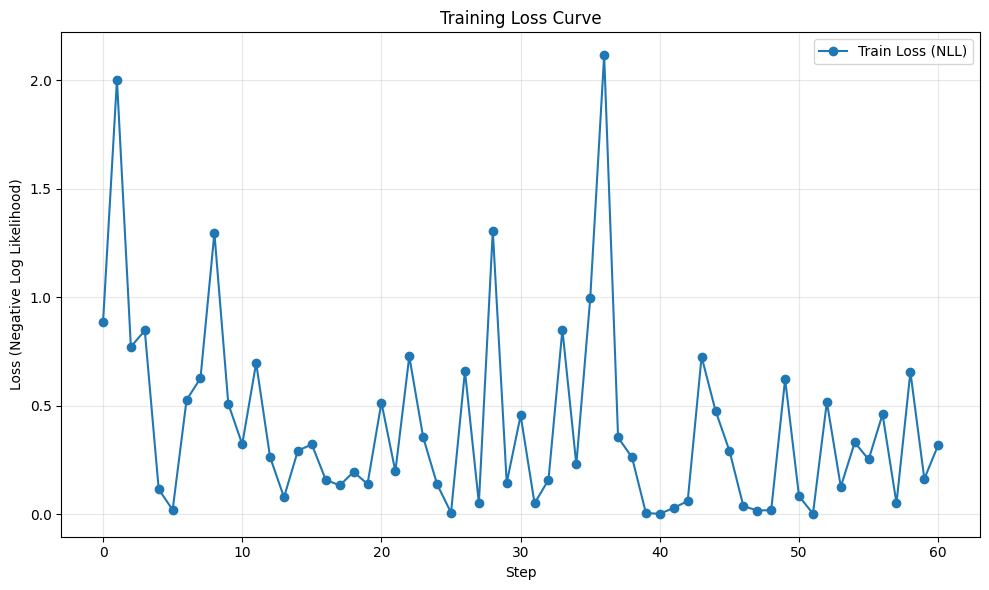


Training Summary:
  Total steps: 61
  Initial loss: 0.8848
  Final loss: 0.3200
  Loss reduction: 0.5648

Available metrics: step, epoch, progress, learning_rate, time/get_batch, time/step, num_sequences, num_tokens, num_loss_tokens, train_mean_nll, time/total, time/save_checkpoint


In [4]:
# Plot training loss curves
import json
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

metrics_file = Path(log_path) / "metrics.jsonl"

if metrics_file.exists():
    # Load metrics
    metrics = []
    with open(metrics_file, "r") as f:
        for line in f:
            metrics.append(json.loads(line))
    
    df = pd.DataFrame(metrics)
    
    # Plot loss curves
    plt.figure(figsize=(10, 6))
    
    if "train_mean_nll" in df.columns:
        plt.plot(df["step"], df["train_mean_nll"], label="Train Loss (NLL)", marker="o")
    
    # Check for test loss if evaluation was enabled
    test_cols = [col for col in df.columns if "test" in col.lower() and "nll" in col.lower()]
    for col in test_cols:
        plt.plot(df["step"], df[col].dropna(), label=col, marker="s")
    
    plt.xlabel("Step")
    plt.ylabel("Loss (Negative Log Likelihood)")
    plt.title("Training Loss Curve")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nTraining Summary:")
    print(f"  Total steps: {len(df)}")
    if "train_mean_nll" in df.columns:
        print(f"  Initial loss: {df['train_mean_nll'].iloc[0]:.4f}")
        print(f"  Final loss: {df['train_mean_nll'].iloc[-1]:.4f}")
        print(f"  Loss reduction: {df['train_mean_nll'].iloc[0] - df['train_mean_nll'].iloc[-1]:.4f}")
    
    # Show available metrics
    print(f"\nAvailable metrics: {', '.join(df.columns)}")
else:
    print(f"Metrics file not found at {metrics_file}")
    print("Training may not have completed or metrics weren't logged.")


In [9]:
# Simple Evaluation: Compare base model vs finetuned model on test dataset

async def run_simple_evaluation():
    from tinker_cookbook import checkpoint_utils, renderers
    from tinker_cookbook.eval.custom_evaluators import CustomEvaluator
    from tinker_cookbook.supervised.data import FromConversationFileBuilder
    from tinker_cookbook.supervised.types import ChatDatasetBuilderCommonConfig
    from tinker_cookbook.renderers import TrainOnWhat
    import tinker
    from tinker import types
    
    service_client = tinker.ServiceClient()
    
    # Get the final checkpoint path from the training run
    checkpoint_info = checkpoint_utils.get_last_checkpoint(log_path, required_key="sampler_path")
    
    if not checkpoint_info:
        print("No checkpoint found. Please run Cell 1 first to train the model.")
        return
    
    model_path = checkpoint_info["sampler_path"]
    print(f"Using model path from training: {model_path}")
    
    # Recreate the dataset builder to get the test dataset
    repo_root = Path.cwd()
    example_data_path = repo_root / "tinker_cookbook" / "example_data" / "conversations.jsonl"
    if not example_data_path.exists():
        example_data_path = repo_root.parent / "tinker_cookbook" / "example_data" / "conversations.jsonl"
    
    common_config = ChatDatasetBuilderCommonConfig(
        model_name_for_tokenizer=model_name,
        renderer_name=renderer_name,
        max_length=8192,
        batch_size=1,  # Evaluate one at a time
        train_on_what=TrainOnWhat.ALL_ASSISTANT_MESSAGES,
    )
    
    dataset_builder = FromConversationFileBuilder(
        common_config=common_config,
        file_path=str(example_data_path),
        test_size=5,
        shuffle_seed=42,
    )
    
    _, test_dataset = dataset_builder()
    
    if test_dataset is None:
        print("No test dataset available for evaluation.")
        return
    
    # Create a simple test dataset from the test split
    # Extract user messages and expected assistant responses
    test_data = []
    for i in range(len(test_dataset)):
        batch = test_dataset.get_batch(i)
        for datum in batch:
            # Extract the conversation from the datum
            # The datum contains the full conversation, we need to extract user/assistant pairs
            # Get the last user message and expected assistant response
            # This is a simplified approach - in practice you'd parse the full conversation
            # For now, we'll just evaluate on a few examples
            if len(test_data) < 5:  # Limit to 5 test examples
                # Create a simple evaluator that checks if model generates reasonable responses
                test_data.append({
                    "input": f"Test example {len(test_data) + 1}",
                    "datum": datum
                })
    
    # Simple grader function - checks if response is non-empty
    def simple_grader(response: str, target: str) -> bool:
        # For this demo, just check if we got a non-empty response
        return len(response.strip()) > 0
    
    # Create base model sampling client
    print("\nCreating base model sampling client (pre-finetuned)...")
    base_sampling_client = service_client.create_sampling_client(
        base_model=model_name
    )
    
    # Create finetuned model sampling client
    print("Creating finetuned model sampling client...")
    finetuned_sampling_client = service_client.create_sampling_client(
        model_path=model_path,
        base_model=model_name
    )
    
    # Evaluate using a simple approach: generate responses and check quality
    print("\nEvaluating on test dataset...")
    
    from tinker_cookbook.tokenizer_utils import get_tokenizer
    tokenizer = get_tokenizer(model_name)
    renderer = renderers.get_renderer(renderer_name, tokenizer)
    
    sampling_params = types.SamplingParams(
        max_tokens=200,
        temperature=0.7,
        top_p=1.0,
        stop=renderer.get_stop_sequences(),
    )
    
    # Load the original conversations to get the user prompts
    # We need to extract just the user messages, not the full training datum
    import json
    conversations = []
    with open(example_data_path, "r") as f:
        for line in f:
            conversations.append(json.loads(line))
    
    # Get the test conversations (last 5 after shuffle)
    # We use the same shuffle seed to match the test split
    import random
    random.seed(42)
    shuffled = conversations.copy()
    random.shuffle(shuffled)
    test_conversations = shuffled[:5]  # First 5 are test (matching test_size=5)
    
    print(f"\nEvaluating on {len(test_conversations)} test conversations...")
    
    # Evaluate base model
    print("\nEvaluating base model...")
    base_responses = []
    for i, conv in enumerate(test_conversations):
        messages = conv["messages"]
        # Get all messages except the last assistant message (that's what we're predicting)
        prompt_messages = messages[:-1] if messages[-1]["role"] == "assistant" else messages
        
        # Build generation prompt
        model_input = renderer.build_generation_prompt(prompt_messages)
        
        try:
            r = await base_sampling_client.sample_async(
                prompt=model_input,
                num_samples=1,
                sampling_params=sampling_params
            )
            tokens = r.sequences[0].tokens
            parsed = renderer.parse_response(tokens)
            if parsed:
                content = parsed[0].get("content", "")
                base_responses.append(content)
                print(f"  Example {i+1}: Generated {len(content)} chars")
            else:
                base_responses.append("")
                print(f"  Example {i+1}: Empty response")
        except Exception as e:
            print(f"  Example {i+1}: Error - {e}")
            base_responses.append("")
    
    # Evaluate finetuned model
    print("\nEvaluating finetuned model...")
    finetuned_responses = []
    for i, conv in enumerate(test_conversations):
        messages = conv["messages"]
        # Get all messages except the last assistant message
        prompt_messages = messages[:-1] if messages[-1]["role"] == "assistant" else messages
        
        # Build generation prompt
        model_input = renderer.build_generation_prompt(prompt_messages)
        
        try:
            r = await finetuned_sampling_client.sample_async(
                prompt=model_input,
                num_samples=1,
                sampling_params=sampling_params
            )
            tokens = r.sequences[0].tokens
            parsed = renderer.parse_response(tokens)
            if parsed:
                content = parsed[0].get("content", "")
                finetuned_responses.append(content)
                print(f"  Example {i+1}: Generated {len(content)} chars")
            else:
                finetuned_responses.append("")
                print(f"  Example {i+1}: Empty response")
        except Exception as e:
            print(f"  Example {i+1}: Error - {e}")
            finetuned_responses.append("")
    
    # Simple metrics: average response length
    base_non_empty = [r for r in base_responses if r]
    finetuned_non_empty = [r for r in finetuned_responses if r]
    
    base_avg_length = sum(len(r) for r in base_non_empty) / len(base_non_empty) if base_non_empty else 0
    finetuned_avg_length = sum(len(r) for r in finetuned_non_empty) / len(finetuned_non_empty) if finetuned_non_empty else 0
    
    print("\n" + "="*60)
    print("Simple Evaluation Results:")
    print("="*60)
    print(f"Base model:")
    print(f"  Average response length: {base_avg_length:.1f} characters")
    print(f"  Non-empty responses: {len(base_non_empty)}/{len(base_responses)}")
    print(f"\nFinetuned model:")
    print(f"  Average response length: {finetuned_avg_length:.1f} characters")
    print(f"  Non-empty responses: {len(finetuned_non_empty)}/{len(finetuned_responses)}")
    
    if base_non_empty:
        print(f"\nBase model responses (first 2):")
        for i, resp in enumerate(base_non_empty[:2]):
            print(f"  {i+1}. {resp[:150]}...")
    else:
        print("\n⚠️  Base model produced no responses")
    
    if finetuned_non_empty:
        print(f"\nFinetuned model responses (first 2):")
        for i, resp in enumerate(finetuned_non_empty[:2]):
            print(f"  {i+1}. {resp[:150]}...")
    else:
        print("\n⚠️  Finetuned model produced no responses")
    
    print("\nNote: This is a simple evaluation. See next cell for Inspect AI evaluation.")

# Run the simple evaluation
await run_simple_evaluation()


tinker.lib.public_interfaces.service_client:66 [INFO] ServiceClient initialized for session cd42e610-c803-54dd-adc3-4056269f18af


[12/23/25 17:19:33] INFO     ServiceClient initialized for session                             ]8;id=712047;file:///Users/rohansubramani/repos/tinker-cookbook/.venv/lib/python3.11/site-packages/tinker/lib/public_interfaces/service_client.py\service_client.py]8;;\:]8;id=569214;file:///Users/rohansubramani/repos/tinker-cookbook/.venv/lib/python3.11/site-packages/tinker/lib/public_interfaces/service_client.py#66\66]8;;\
                             cd42e610-c803-54dd-adc3-4056269f18af                                                  

tinker_cookbook.checkpoint_utils:24 [INFO] Reading checkpoints from /tmp/tinker-test/checkpoints.jsonl


                    INFO     Reading checkpoints from /tmp/tinker-test/checkpoints.jsonl     ]8;id=183562;file:///Users/rohansubramani/repos/tinker-cookbook/tinker_cookbook/checkpoint_utils.py\checkpoint_utils.py]8;;\:]8;id=14167;file:///Users/rohansubramani/repos/tinker-cookbook/tinker_cookbook/checkpoint_utils.py#24\24]8;;\

tinker_cookbook.checkpoint_utils:46 [INFO] Found 13 valid checkpoints with key 'sampler_path' in /tmp/tinker-test


                    INFO     Found 13 valid checkpoints with key 'sampler_path' in           ]8;id=360821;file:///Users/rohansubramani/repos/tinker-cookbook/tinker_cookbook/checkpoint_utils.py\checkpoint_utils.py]8;;\:]8;id=314409;file:///Users/rohansubramani/repos/tinker-cookbook/tinker_cookbook/checkpoint_utils.py#46\46]8;;\
                             /tmp/tinker-test                                                                      

tinker_cookbook.checkpoint_utils:49 [INFO] Using last checkpoint: {'name': 'final', 'epoch': 1, 'batch': 61, 'state_path': 'tinker://9a59b975-a813-56b8-95f1-e97245ca9dda:train:0/weights/final', 'sampler_path': 'tinker://9a59b975-a813-56b8-95f1-e97245ca9dda:train:0/sampler_weights/final'}


                    INFO     Using last checkpoint: {'name': 'final', 'epoch': 1, 'batch':   ]8;id=73542;file:///Users/rohansubramani/repos/tinker-cookbook/tinker_cookbook/checkpoint_utils.py\checkpoint_utils.py]8;;\:]8;id=114448;file:///Users/rohansubramani/repos/tinker-cookbook/tinker_cookbook/checkpoint_utils.py#49\49]8;;\
                             61, 'state_path':                                                                     
                             'tinker://9a59b975-a813-56b8-95f1-e97245ca9dda:train:0/weights/                       
                             final', 'sampler_path':                                                               
                             'tinker://9a59b975-a813-56b8-95f1-e97245ca9dda:train:0/sampler_                       
                             weights/final'}                                                                       

Using model path from training: tinker://9a59b975-a813-56b8-95f1-e97245ca9dda:train:0/sampler_weights/final

Creating base model sampling client (pre-finetuned)...
Creating finetuned model sampling client...

Evaluating on test dataset...

Evaluating on 5 test conversations...

Evaluating base model...
  Example 1: Generated 991 chars
  Example 2: Generated 254 chars
  Example 3: Generated 832 chars
  Example 4: Generated 25 chars
  Example 5: Generated 514 chars

Evaluating finetuned model...
  Example 1: Generated 52 chars
  Example 2: Generated 64 chars
  Example 3: Generated 60 chars
  Example 4: Generated 25 chars
  Example 5: Generated 90 chars

Simple Evaluation Results:
Base model:
  Average response length: 523.2 characters
  Non-empty responses: 5/5

Finetuned model:
  Average response length: 58.2 characters
  Non-empty responses: 5/5

Base model responses (first 2):
  1. One of the most frequently asked questions in science!

The sky appears blue because of a phenomenon cal

In [8]:
# Inspect AI Evaluation: Try to use standard inspect_ai tasks
# This follows the pattern from tinker_cookbook/eval/run_inspect_evals.py

async def run_inspect_evaluation():
    import logging
    from tinker_cookbook import checkpoint_utils
    from tinker_cookbook.eval.inspect_evaluators import InspectEvaluator, InspectEvaluatorBuilder
    import tinker
    
    logging.basicConfig(level=logging.INFO)
    logger = logging.getLogger(__name__)
    
    service_client = tinker.ServiceClient()
    
    # Get the final checkpoint path from the training run
    checkpoint_info = checkpoint_utils.get_last_checkpoint(log_path, required_key="sampler_path")
    
    if not checkpoint_info:
        print("No checkpoint found. Please run Cell 1 first to train the model.")
        return
    
    model_path = checkpoint_info["sampler_path"]
    print(f"Using model path from training: {model_path}")
    
    # Get base model name from checkpoint if available, otherwise use the one from training
    if model_path:
        try:
            rest_client = service_client.create_rest_client()
            training_run = await rest_client.get_training_run_by_tinker_path_async(model_path)
            eval_model_name = training_run.base_model
            print(f"Detected base model from checkpoint: {eval_model_name}")
        except Exception as e:
            print(f"Could not get model name from checkpoint, using: {model_name}")
            eval_model_name = model_name
    else:
        eval_model_name = model_name
    
    # Create sampling clients
    print("\nCreating base model sampling client...")
    base_sampling_client = service_client.create_sampling_client(
        base_model=eval_model_name
    )
    
    print("Creating finetuned model sampling client...")
    finetuned_sampling_client = service_client.create_sampling_client(
        model_path=model_path,
        base_model=eval_model_name
    )
    
    # Try different task specifications
    # The inspect_ai library may require tasks to be specified differently
    # Let's try a few common patterns
    
    task_options = [
        "inspect_evals/ifeval",  # Standard format
        "ifeval",  # Just the task name
        ["inspect_evals/ifeval"],  # As a list
    ]
    
    # Also try to import and check what tasks are available
    try:
        from inspect_ai import list_tasks
        print("\nAvailable inspect tasks:")
        available_tasks = list_tasks()
        if available_tasks:
            print(f"  Found {len(available_tasks)} tasks")
            # Show first few
            for task in list(available_tasks)[:10]:
                print(f"    - {task}")
            # Look for ifeval specifically
            ifeval_tasks = [t for t in available_tasks if "ifeval" in str(t).lower()]
            if ifeval_tasks:
                print(f"\n  Found ifeval-related tasks: {ifeval_tasks}")
                task_options.insert(0, ifeval_tasks[0])  # Use the first one found
        else:
            print("  No tasks found. You may need to install inspect_ai tasks.")
            print("  Try: pip install inspect-ai[all] or inspect-ai[ifeval]")
    except Exception as e:
        print(f"  Could not list tasks: {e}")
        print("  Continuing with default task options...")
    
    # Try each task option until one works
    base_metrics = None
    finetuned_metrics = None
    
    for task_spec in task_options:
        try:
            print(f"\n{'='*60}")
            print(f"Trying task specification: {task_spec}")
            print(f"{'='*60}")
            
            evaluator_config = InspectEvaluatorBuilder(
                tasks=task_spec,
                renderer_name=renderer_name,
                model_name=eval_model_name,
                limit=3,  # Small limit for quick demo
                temperature=0.0,
                max_tokens=500,
                debug_errors=True,
            )
            
            # Evaluate base model
            print("\nEvaluating base model...")
            base_evaluator = InspectEvaluator(evaluator_config)
            base_metrics = await base_evaluator(base_sampling_client)
            
            print("\nBase model metrics:")
            for metric_name, metric_value in base_metrics.items():
                print(f"  {metric_name}: {metric_value:.4f}")
            
            # Evaluate finetuned model
            print("\nEvaluating finetuned model...")
            finetuned_evaluator = InspectEvaluator(evaluator_config)
            finetuned_metrics = await finetuned_evaluator(finetuned_sampling_client)
            
            print("\nFinetuned model metrics:")
            for metric_name, metric_value in finetuned_metrics.items():
                print(f"  {metric_name}: {metric_value:.4f}")
            
            # Success! Break out of the loop
            break
            
        except Exception as e:
            print(f"  ❌ Failed with task '{task_spec}': {e}")
            import traceback
            traceback.print_exc()
            continue
    
    if base_metrics and finetuned_metrics:
        # Compare results
        print("\n" + "="*60)
        print("Inspect AI Evaluation Comparison:")
        print("="*60)
        all_metrics = set(base_metrics.keys()) | set(finetuned_metrics.keys())
        for metric_name in sorted(all_metrics):
            base_val = base_metrics.get(metric_name, 0)
            finetuned_val = finetuned_metrics.get(metric_name, 0)
            diff = finetuned_val - base_val
            print(f"{metric_name}:")
            print(f"  Base:      {base_val:.4f}")
            print(f"  Finetuned: {finetuned_val:.4f}")
            print(f"  Change:    {diff:+.4f}")
        print("\n✅ Inspect AI evaluation completed successfully!")
    else:
        print("\n❌ Could not run Inspect AI evaluation with any task specification.")
        print("This may be because:")
        print("  1. Inspect AI tasks are not installed (try: pip install inspect-ai[all])")
        print("  2. The task name format is incorrect")
        print("  3. There's a compatibility issue with the inspect_ai version")
        print("\nThe simple evaluation in the previous cell should still work.")

# Run the inspect evaluation
await run_inspect_evaluation()


tinker.lib.public_interfaces.service_client:66 [INFO] ServiceClient initialized for session badbff8e-b377-5496-b737-0787259ae964


[12/23/25 16:46:56] INFO     ServiceClient initialized for session                             ]8;id=140113;file:///Users/rohansubramani/repos/tinker-cookbook/.venv/lib/python3.11/site-packages/tinker/lib/public_interfaces/service_client.py\service_client.py]8;;\:]8;id=293958;file:///Users/rohansubramani/repos/tinker-cookbook/.venv/lib/python3.11/site-packages/tinker/lib/public_interfaces/service_client.py#66\66]8;;\
                             badbff8e-b377-5496-b737-0787259ae964                                                  

tinker_cookbook.checkpoint_utils:24 [INFO] Reading checkpoints from /tmp/tinker-test/checkpoints.jsonl


                    INFO     Reading checkpoints from /tmp/tinker-test/checkpoints.jsonl     ]8;id=892465;file:///Users/rohansubramani/repos/tinker-cookbook/tinker_cookbook/checkpoint_utils.py\checkpoint_utils.py]8;;\:]8;id=983550;file:///Users/rohansubramani/repos/tinker-cookbook/tinker_cookbook/checkpoint_utils.py#24\24]8;;\

tinker_cookbook.checkpoint_utils:46 [INFO] Found 13 valid checkpoints with key 'sampler_path' in /tmp/tinker-test


                    INFO     Found 13 valid checkpoints with key 'sampler_path' in           ]8;id=196027;file:///Users/rohansubramani/repos/tinker-cookbook/tinker_cookbook/checkpoint_utils.py\checkpoint_utils.py]8;;\:]8;id=328572;file:///Users/rohansubramani/repos/tinker-cookbook/tinker_cookbook/checkpoint_utils.py#46\46]8;;\
                             /tmp/tinker-test                                                                      

tinker_cookbook.checkpoint_utils:49 [INFO] Using last checkpoint: {'name': 'final', 'epoch': 1, 'batch': 61, 'state_path': 'tinker://9a59b975-a813-56b8-95f1-e97245ca9dda:train:0/weights/final', 'sampler_path': 'tinker://9a59b975-a813-56b8-95f1-e97245ca9dda:train:0/sampler_weights/final'}


                    INFO     Using last checkpoint: {'name': 'final', 'epoch': 1, 'batch':   ]8;id=147564;file:///Users/rohansubramani/repos/tinker-cookbook/tinker_cookbook/checkpoint_utils.py\checkpoint_utils.py]8;;\:]8;id=894316;file:///Users/rohansubramani/repos/tinker-cookbook/tinker_cookbook/checkpoint_utils.py#49\49]8;;\
                             61, 'state_path':                                                                     
                             'tinker://9a59b975-a813-56b8-95f1-e97245ca9dda:train:0/weights/                       
                             final', 'sampler_path':                                                               
                             'tinker://9a59b975-a813-56b8-95f1-e97245ca9dda:train:0/sampler_                       
                             weights/final'}                                                                       

Using model path from training: tinker://9a59b975-a813-56b8-95f1-e97245ca9dda:train:0/sampler_weights/final
Detected base model from checkpoint: meta-llama/Llama-3.1-8B-Instruct

Creating base model sampling client...
Creating finetuned model sampling client...

Available inspect tasks:
  Found 1 tasks
    - tinker_cookbook/eval/custom_inspect_task.py@example_lm_as_judge

Trying task specification: inspect_evals/ifeval

Evaluating base model...
  ❌ Failed with task 'inspect_evals/ifeval': Error: No inspect tasks were found at the specified paths.

Trying task specification: ifeval

Evaluating base model...
  ❌ Failed with task 'ifeval': Error: No inspect tasks were found at the specified paths.

Trying task specification: ['inspect_evals/ifeval']

Evaluating base model...
  ❌ Failed with task '['inspect_evals/ifeval']': Error: No inspect tasks were found at the specified paths.

❌ Could not run Inspect AI evaluation with any task specification.
This may be because:
  1. Inspect AI task

  + Exception Group Traceback (most recent call last):
  |   File "/Users/rohansubramani/repos/tinker-cookbook/.venv/lib/python3.11/site-packages/inspect_ai/_eval/eval.py", line 450, in eval_async
  |     async with anyio.create_task_group() as tg:
  |   File "/Users/rohansubramani/repos/tinker-cookbook/.venv/lib/python3.11/site-packages/anyio/_backends/_asyncio.py", line 783, in __aexit__
  |     raise BaseExceptionGroup(
  | ExceptionGroup: unhandled errors in a TaskGroup (1 sub-exception)
  +-+---------------- 1 ----------------
    | Traceback (most recent call last):
    |   File "/var/folders/hm/71fvffys2rvccwcjd1b5nqfc0000gn/T/ipykernel_7940/2435724126.py", line 105, in run_inspect_evaluation
    |     base_metrics = await base_evaluator(base_sampling_client)
    |                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    |   File "/Users/rohansubramani/repos/tinker-cookbook/tinker_cookbook/eval/inspect_evaluators.py", line 87, in __call__
    |     results = await eval_